In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from easydict import EasyDict as edict
import numpy as np

from PIL import Image, ImageDraw
from IPython.display import display

def draw_point(im_path: Path, list_points_2d): 
    im = Image.open(im_path) 
    draw = ImageDraw.Draw(im)

    point_size = 5
    point_color = (255, 0, 0)  # red
    for point in list_points_2d:
        draw.ellipse([(point[0] - point_size // 2, point[1] - point_size // 2),
                    (point[0] + point_size // 2, point[1] + point_size // 2)],
                    fill=point_color)
    return im

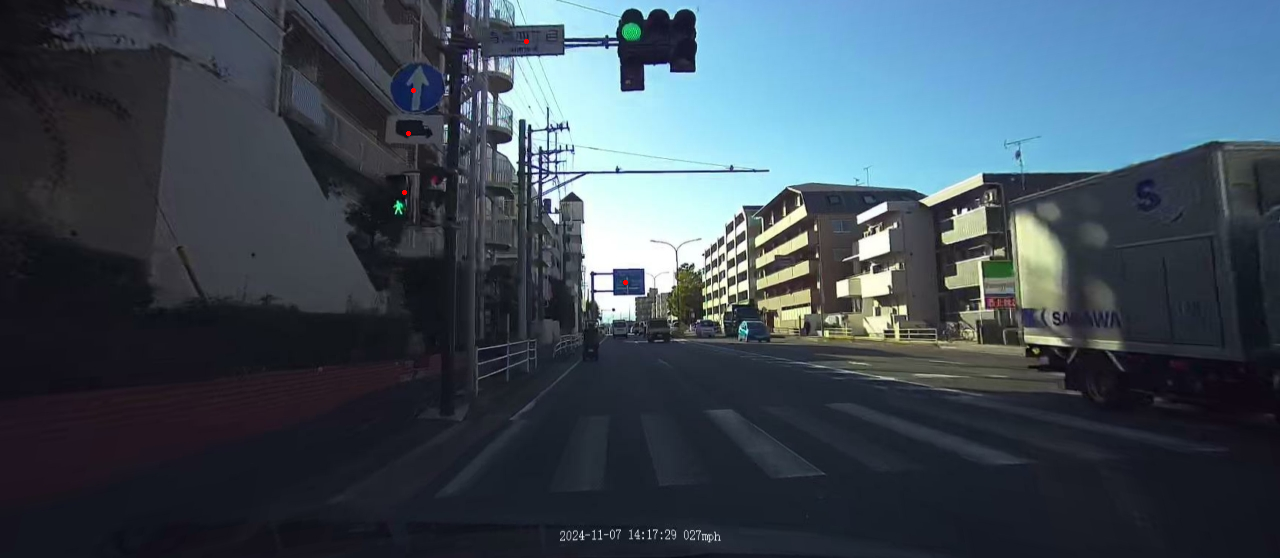

In [20]:
# Assignment: fill in the function questions  then play with diffferent image_number and change the is_distorted flag to True
# Answer the questions
#             how would you call the number d returned by the function
#             what is ecef
#             why are the pose for distorted equal to those of undistorted
#             why the intrinsics do not depend on image name
#             why does this not look good for is_distorted = True and what can we do about it

import numpy as np

import numpy as np

def project_pinhole(p, intrinsics, pose, apply_distortion=False, debug=False):
    """
    Project a 3D point using the pinhole camera model with optional radial distortion
    
    Args:
        p: A (3,1) numpy array representing a 3D point in world coordinates (ECEF)
        intrinsics: with fields fx, fy, cx, cy (camera intrinsic parameters)
                   and optionally k1, k2 for radial distortion
        pose: with fields R (3x3 rotation matrix), t (3x1 translation vector)
              Note: t is the camera position in world coordinates
        apply_distortion: bool, whether to apply radial distortion using k1, k2
        debug: bool, whether to print debug information
    
    Returns:
        tuple: (x_sensor, y_sensor, d) where:
               - x_sensor, y_sensor are pixel coordinates on the image sensor
               - d is the distance from camera to the point
    """
    
    # Extract rotation matrix and translation vector from pose
    R = pose['R']  # 3x3 rotation matrix from world to camera
    t = pose['t']  # 3x1 camera position in world coordinates
    
    # DEBUG: Print values to understand what's happening
    if debug:
        print(f"Point p: {p.flatten()}")
        print(f"Camera position t: {t.flatten()}")
        print(f"p - t: {(p - t).flatten()}")
        print(f"Apply distortion: {apply_distortion}")
    
    # Transform point from world coordinates to camera coordinates
    # According to the note in the original code: t here is equal to -Rt from the lecture
    # So we use: p_camera = R @ p + t (instead of R @ (p - t))
    p_camera = R @ p + t
    if debug:
        print(f"p_camera: {p_camera.flatten()}")
    
    # Extract coordinates in camera frame
    X_cam = p_camera[0, 0]  # X coordinate in camera frame
    Y_cam = p_camera[1, 0]  # Y coordinate in camera frame  
    Z_cam = p_camera[2, 0]  # Z coordinate in camera frame (depth)
    if debug:
        print(f"Z_cam (depth): {Z_cam}")
        print("---")
        
    # Check if point is behind the camera (negative Z)
    if Z_cam <= 0:
        # Point is behind camera or at camera plane - cannot project
        if debug:
            print("Point is behind camera!")
        return float('nan'), float('nan'), float('nan')
    
    # Apply perspective projection to get normalized coordinates
    x_normalized = X_cam / Z_cam
    y_normalized = Y_cam / Z_cam
    
    if debug:
        print(f"Normalized coordinates (before distortion): x={x_normalized:.6f}, y={y_normalized:.6f}")
    
    # Apply radial distortion if requested and parameters are available
    if apply_distortion and hasattr(intrinsics, 'k1') and hasattr(intrinsics, 'k2'):
        # Calculate squared radius from center
        r_squared = x_normalized**2 + y_normalized**2
        
        # Apply radial distortion model: x_distorted = x * (1 + k1*r² + k2*r⁴)
        distortion_factor = 1 + intrinsics.k1 * r_squared + intrinsics.k2 * r_squared**2
        
        x_normalized *= distortion_factor
        y_normalized *= distortion_factor
        
        if debug:
            print(f"r²: {r_squared:.6f}, distortion_factor: {distortion_factor:.6f}")
            print(f"Distorted normalized coordinates: x={x_normalized:.6f}, y={y_normalized:.6f}")
    
    elif apply_distortion and debug:
        print("Warning: Distortion requested but k1/k2 parameters not found in intrinsics")
    
    # Convert normalized coordinates to pixel coordinates using camera intrinsics
    # Formula: u = fx * x_norm + cx, v = fy * y_norm + cy
    x_sensor = intrinsics.fx * x_normalized + intrinsics.cx
    y_sensor = intrinsics.fy * y_normalized + intrinsics.cy
    
    # Calculate distance from camera to point
    # Using Euclidean distance in 3D camera coordinates
    d = np.sqrt(X_cam**2 + Y_cam**2 + Z_cam**2)
    
    if debug:
        print(f"Final pixel coordinates: x={x_sensor:.2f}, y={y_sensor:.2f}")
        print(f"Distance: {d:.2f} meters")
        print("---")
    
    return x_sensor, y_sensor, d

assets_path = Path('3dv-short-course-images')

segment_id_1 = '275f2690-23e5-4acd-bf99-2a1a97e6e570'   # 2 dmp cameras, have dmp shapes

nexar_images = ['20241107_051651A_mp4__001154.jpg', '20241107_051651A_mp4__001160.jpg']
distorted_images = ['distorted_20241107_051651A_mp4__001154.jpg', 'distorted_20241107_051651A_mp4__001160.jpg']
undistorted_images = ['undistorted_20241107_051651A_mp4__001154.jpg', 'undistorted_20241107_051651A_mp4__001160.jpg']

camera_intrinsics = edict(
    nexar_distorted = edict(
        w=1280,
        h=720,
        camera_model='colmap_radial',
        fx=882.3212892103986,
        fy=882.3212892103986,
        cx=640.0,
        cy=360.0,
        k1=-0.3882772391716781,
        k2=0.11183503504936487
    ),
    nexar_undistorted = edict(
        w=1280,
        h=558,
        camera_model='pinhole',
        fx=636.0676579228768,
        fy=635.6408013930611,
        cx=640.0,
        cy=279.0
    )
)

pose_by_image_name = {
    'distorted_20241107_051651A_mp4__001154.jpg': {
        'R': np.array([[ 0.58879828, -0.21949033,  0.77790782],
                       [ 0.64783314, -0.44737875, -0.61657479],
                       [ 0.48335163,  0.86699265, -0.12122273]]), 
        't': np.array([[ 196574.3537559 ], [6343225.02984402],[-561172.87502357]])}, 
    'distorted_20241107_051651A_mp4__001160.jpg': {
        'R': np.array([[ 0.58887682, -0.21891042,  0.77801178],
                       [ 0.64813116, -0.44719169, -0.61639727],
                       [ 0.48285618,  0.86723574, -0.12145815]]), 
        't': np.array([[ 194548.49906685], [6343118.14276729], [-563084.05932236]])}, 
    'undistorted_20241107_051651A_mp4__001154.jpg': {
        'R': np.array([[ 0.58879828, -0.21949033,  0.77790782],
                       [ 0.64783314, -0.44737875, -0.61657479],
                       [ 0.48335163,  0.86699265, -0.12122273]]), 
         't': np.array([[ 196574.3537559 ], [6343225.02984402], [-561172.87502357]])}, 
    'undistorted_20241107_051651A_mp4__001160.jpg': {
        'R': np.array([[ 0.58887682, -0.21891042,  0.77801178],
                       [ 0.64813116, -0.44719169, -0.61639727],
                       [ 0.48285618,  0.86723574, -0.12145815]]), 
        't': np.array([[ 194548.49906685], [6343118.14276729],[-563084.05932236]])}
}

signs_3d = [
    [-3953848.2207747577, 3367515.524743535, 3690126.4256444126], 
    [-3953847.370960521, 3367514.3233560296, 3690125.512693499], 
    [-3953847.6750817653, 3367515.6303010867, 3690128.228192723], 
    [-3953847.8708120137, 3367515.0007948703, 3690126.0140610617], 
    [-3953814.475204671, 3367568.4366355096, 3690118.165392032] 
]

# p3_ecef = np.array([-3953821.0717477687, 3367498.330574915, 3690107.0067546996]).reshape(3,1)

is_distorted = False
image_number = 1     # 0,1

list_image_names = distorted_images if is_distorted else undistorted_images
intrinsics = camera_intrinsics.nexar_distorted if is_distorted else camera_intrinsics.nexar_undistorted

list_points_2d = []
for s in signs_3d:
    p3_ecef = np.array(s).reshape(3,1)
    image_name = list_image_names[1]
    image_file = assets_path/ image_name

    pose = pose_by_image_name[image_name]

    xsensor, ysensor, d = project_pinhole(p3_ecef, intrinsics, pose)
    list_points_2d.append((xsensor, ysensor))

im = draw_point(image_file, list_points_2d=list_points_2d)
display(im)

In [21]:
list_points_2d

[(413.9031186307014, 90.26562701848468),
 (404.84185895915334, 192.95870639543517),
 (526.0754645614533, 41.287099258984824),
 (408.36515765747265, 133.20847055350015),
 (625.9256166457626, 282.4587306033243)]

Image: undistorted_20241107_051651A_mp4__001154.jpg | Distorted: False


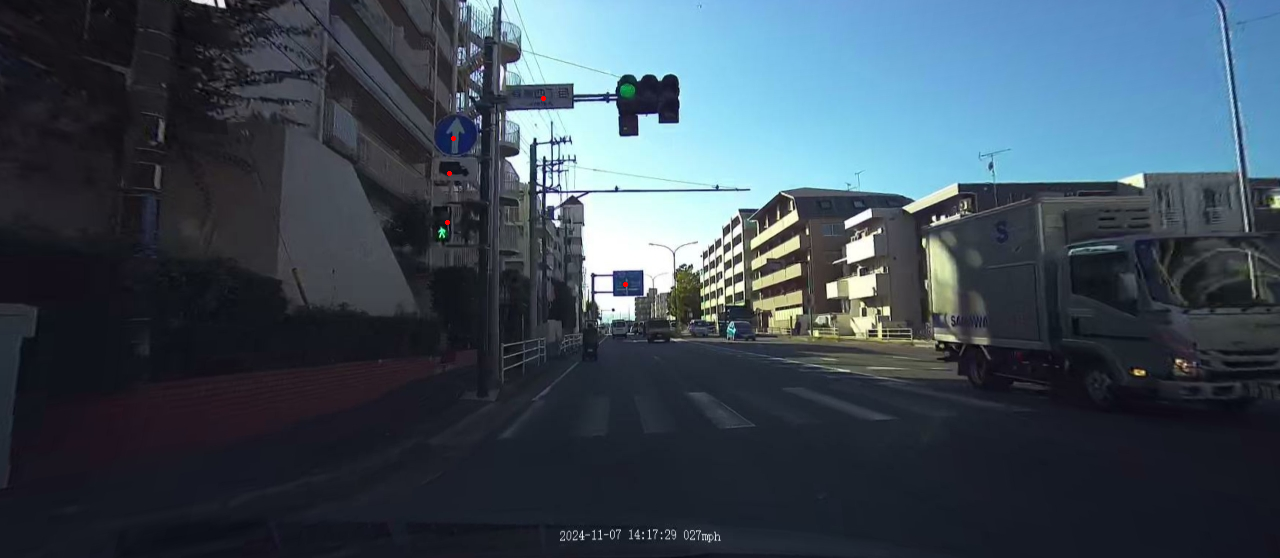

Image: undistorted_20241107_051651A_mp4__001160.jpg | Distorted: False


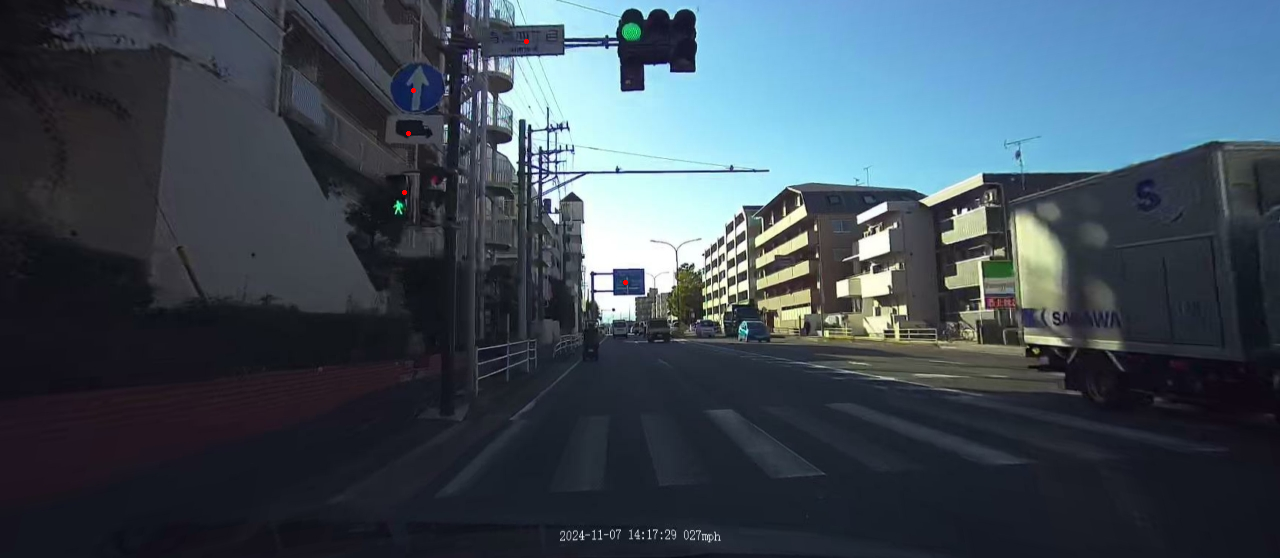

Image: distorted_20241107_051651A_mp4__001154.jpg | Distorted: True


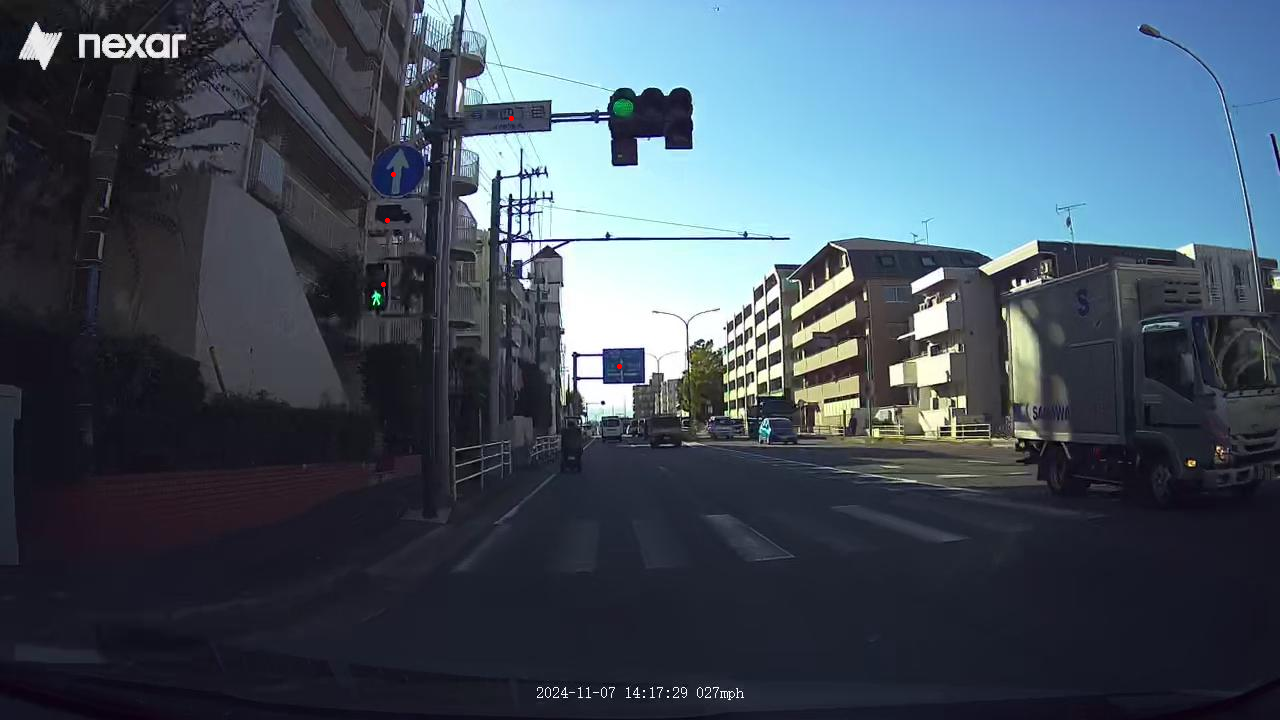

Image: distorted_20241107_051651A_mp4__001160.jpg | Distorted: True


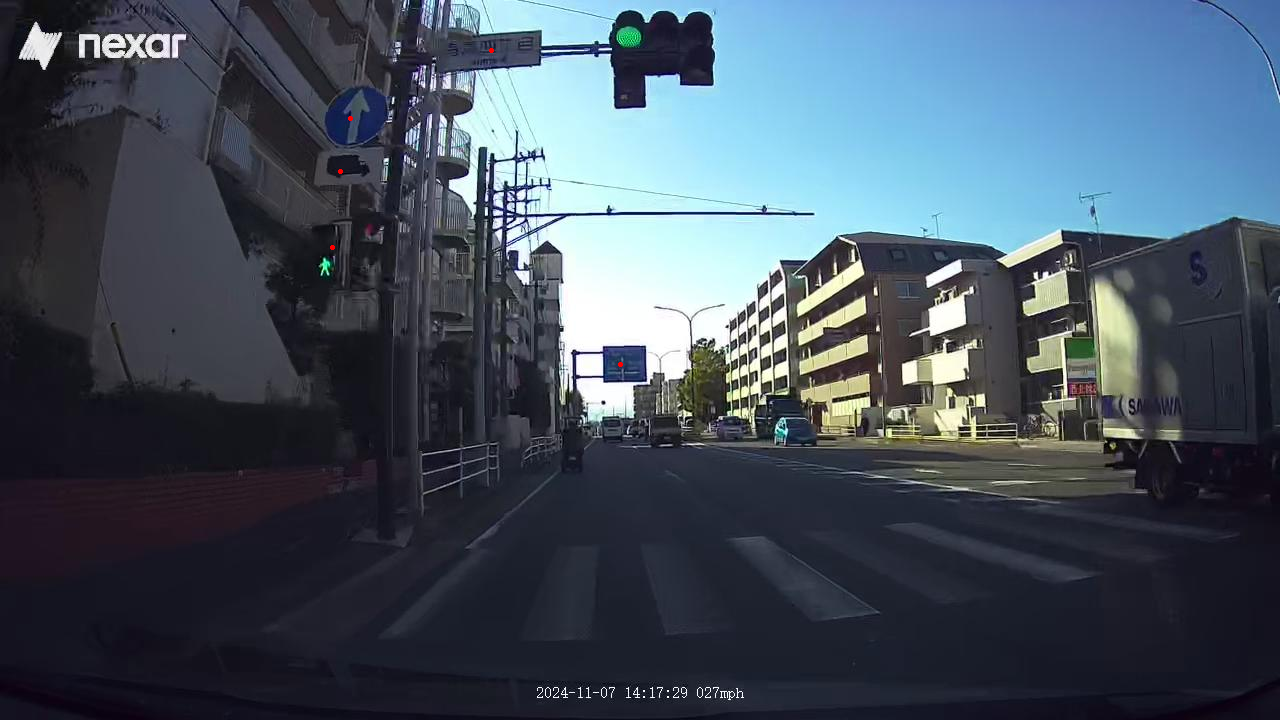

In [24]:
for is_distorted in [False, True]:
    for image_number in [0, 1]:
        list_image_names = distorted_images if is_distorted else undistorted_images
        intrinsics = camera_intrinsics.nexar_distorted if is_distorted else camera_intrinsics.nexar_undistorted

        list_points_2d = []
        for s in signs_3d:
            p3_ecef = np.array(s).reshape(3, 1)
            image_name = list_image_names[image_number]
            image_file = assets_path / image_name

            pose = pose_by_image_name[image_name]

            xsensor, ysensor, d = project_pinhole(p3_ecef, intrinsics, pose, True)
            list_points_2d.append((xsensor, ysensor))

        print(f"Image: {image_name} | Distorted: {is_distorted}")
        im = draw_point(image_file, list_points_2d=list_points_2d)
        display(im)


# Q&A

### 📌 Assignment Questions and Answers

#### ❓ 1. How would you call the number `d` returned by the function?
**Answer:**  
`d` is the **depth** or **Euclidean distance** from the camera to the 3D point, measured in meters.

---

#### ❓ 2. What is ECEF?
**Answer:**  
ECEF stands for **Earth-Centered, Earth-Fixed**.  
It is a global 3D coordinate system where:
- The origin is at the center of the Earth.
- X axis points toward the intersection of the Equator and Prime Meridian.
- Y axis is perpendicular to the X axis in the equatorial plane.
- Z axis goes through the North Pole.

---

#### ❓ 3. Why are the poses for distorted equal to those of undistorted?
**Answer:**  
Because the **camera pose** (position and orientation in space) does not change when distortion is corrected.  
Distortion only affects the image appearance, not the physical location or direction of the camera.

---

#### ❓ 4. Why do the intrinsics not depend on image name?
**Answer:**  
Intrinsics depend on the **camera model and lens parameters**, not on the specific image.  
All images taken with the same camera and processing type (distorted or undistorted) share the same intrinsics.

---

#### ❓ 5. Why does this not look good for `is_distorted = True`, and what can we do about it?
**Answer:**  
When `is_distorted = True`, we project using a pinhole model but the image is still distorted by lens effects.  
As a result, the 2D projection is incorrect because distortion is not compensated.

**What we can do:**
- Either undistort the image first (and use the undistorted intrinsics).
- Or apply a distortion-aware projection using distortion coefficients (`k1`, `k2`) with OpenCV’s `cv2.projectPoints` or a similar model.


In [18]:
import numpy as np

def project_pinhole_enhanced(p, intrinsics, pose, apply_distortion=False, debug=False):
    """
    Project a 3D point using the pinhole camera model with optional radial distortion
    
    Args:
        p: A (3,1) numpy array representing a 3D point in world coordinates (ECEF)
        intrinsics: with fields fx, fy, cx, cy (camera intrinsic parameters)
                   and optionally k1, k2 for radial distortion
        pose: with fields R (3x3 rotation matrix), t (3x1 translation vector)
              Note: t is the camera position in world coordinates
        apply_distortion: bool, whether to apply radial distortion using k1, k2
        debug: bool, whether to print debug information
    
    Returns:
        tuple: (x_sensor, y_sensor, d) where:
               - x_sensor, y_sensor are pixel coordinates on the image sensor
               - d is the distance from camera to the point
    """
    
    # Extract rotation matrix and translation vector from pose
    R = pose['R']  # 3x3 rotation matrix from world to camera
    t = pose['t']  # 3x1 camera position in world coordinates
    
    # DEBUG: Print values to understand what's happening
    if debug:
        print(f"Point p: {p.flatten()}")
        print(f"Camera position t: {t.flatten()}")
        print(f"Apply distortion: {apply_distortion}")
        if apply_distortion and hasattr(intrinsics, 'k1'):
            print(f"Distortion params - k1: {intrinsics.k1}, k2: {intrinsics.k2}")
    
    # Transform point from world coordinates to camera coordinates
    # According to the note in the original code: t here is equal to -Rt from the lecture
    # So we use: p_camera = R @ p + t (instead of R @ (p - t))
    p_camera = R @ p + t
    
    if debug:
        print(f"p_camera: {p_camera.flatten()}")
    
    # Extract coordinates in camera frame
    X_cam = p_camera[0, 0]  # X coordinate in camera frame
    Y_cam = p_camera[1, 0]  # Y coordinate in camera frame  
    Z_cam = p_camera[2, 0]  # Z coordinate in camera frame (depth)
    
    if debug:
        print(f"Camera coordinates - X: {X_cam:.3f}, Y: {Y_cam:.3f}, Z: {Z_cam:.3f}")
    
    # Check if point is behind the camera (negative Z)
    if Z_cam <= 0:
        if debug:
            print("Point is behind camera!")
        return float('nan'), float('nan'), float('nan')
    
    # Apply perspective projection to get normalized coordinates
    x_normalized = X_cam / Z_cam
    y_normalized = Y_cam / Z_cam
    
    if debug:
        print(f"Normalized coordinates (before distortion): x={x_normalized:.6f}, y={y_normalized:.6f}")
    
    # Apply radial distortion if requested and parameters are available
    if apply_distortion and hasattr(intrinsics, 'k1') and hasattr(intrinsics, 'k2'):
        # Calculate squared radius from center
        r_squared = x_normalized**2 + y_normalized**2
        
        # Apply radial distortion model: x_distorted = x * (1 + k1*r² + k2*r⁴)
        distortion_factor = 1 + intrinsics.k1 * r_squared + intrinsics.k2 * r_squared**2
        
        x_normalized_distorted = x_normalized * distortion_factor
        y_normalized_distorted = y_normalized * distortion_factor
        
        if debug:
            print(f"r²: {r_squared:.6f}")
            print(f"Distortion factor: {distortion_factor:.6f}")
            print(f"Distorted normalized coordinates: x={x_normalized_distorted:.6f}, y={y_normalized_distorted:.6f}")
        
        # Use distorted coordinates for final projection
        x_normalized = x_normalized_distorted
        y_normalized = y_normalized_distorted
    
    elif apply_distortion:
        if debug:
            print("Warning: Distortion requested but k1/k2 parameters not found in intrinsics")
    
    # Convert normalized coordinates to pixel coordinates using camera intrinsics
    # Formula: u = fx * x_norm + cx, v = fy * y_norm + cy
    x_sensor = intrinsics.fx * x_normalized + intrinsics.cx
    y_sensor = intrinsics.fy * y_normalized + intrinsics.cy
    
    # Calculate distance from camera to point
    # Using Euclidean distance in 3D camera coordinates
    d = np.sqrt(X_cam**2 + Y_cam**2 + Z_cam**2)
    
    if debug:
        print(f"Final pixel coordinates: x={x_sensor:.2f}, y={y_sensor:.2f}")
        print(f"Distance: {d:.2f} meters")
        print("---")
    
    return x_sensor, y_sensor, d


# Helper function to automatically determine distortion mode based on camera model
def project_pinhole_auto(p, intrinsics, pose, debug=False):
    """
    Automatically determine whether to apply distortion based on camera model
    """
    apply_distortion = False
    
    # Check if this is a distorted camera model
    if hasattr(intrinsics, 'camera_model'):
        if 'radial' in intrinsics.camera_model.lower() or 'colmap' in intrinsics.camera_model.lower():
            apply_distortion = True
    
    return project_pinhole_enhanced(p, intrinsics, pose, apply_distortion=apply_distortion, debug=debug)


# Updated main projection loop that uses the enhanced function
def project_signs_enhanced(signs_3d, intrinsics, pose, apply_distortion=False, debug=False):
    """
    Project multiple 3D points to image coordinates
    """
    list_points_2d = []
    
    for i, s in enumerate(signs_3d):
        p3_ecef = np.array(s).reshape(3, 1)
        
        if debug:
            print(f"\n=== Processing sign {i+1} ===")
        
        x_sensor, y_sensor, d = project_pinhole_enhanced(
            p3_ecef, intrinsics, pose, 
            apply_distortion=apply_distortion, 
            debug=debug
        )
        
        # Only add valid projections (not NaN)
        if not (np.isnan(x_sensor) or np.isnan(y_sensor)):
            list_points_2d.append((x_sensor, y_sensor))
        elif debug:
            print(f"Skipping sign {i+1} - invalid projection")
    
    return list_points_2d

Processing image: distorted_20241107_051651A_mp4__001160.jpg
Using distorted camera model


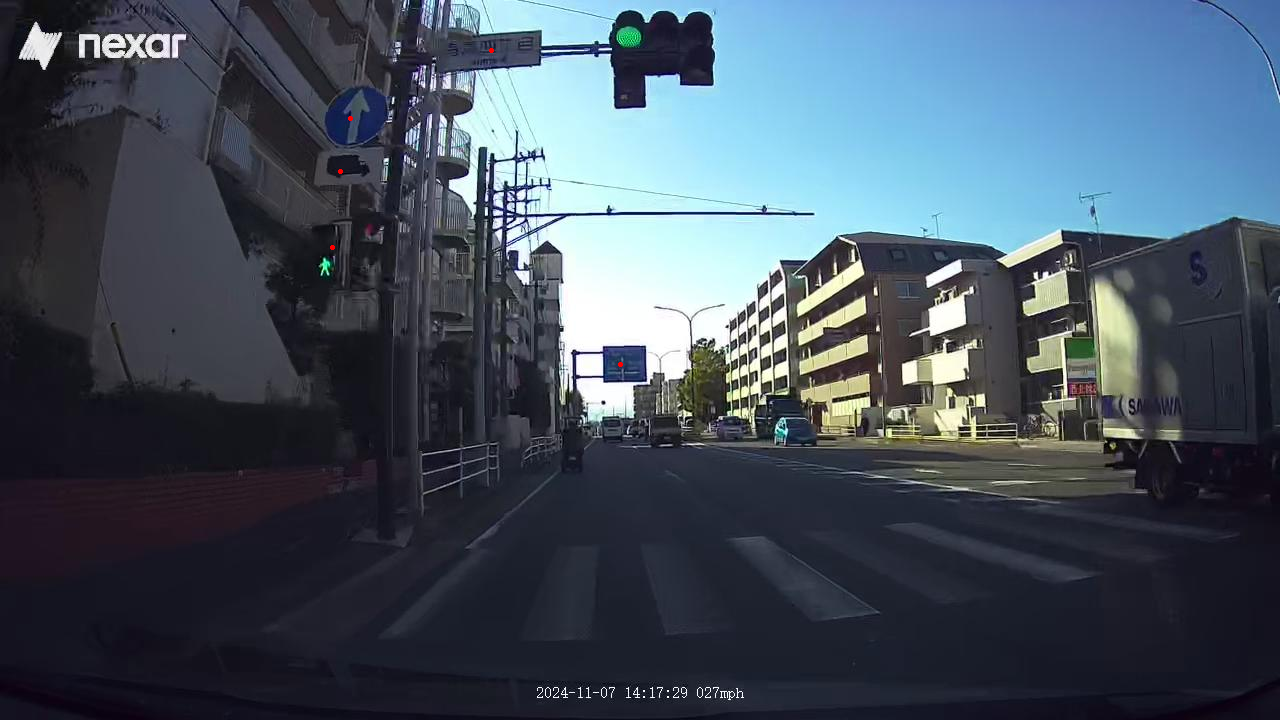

Successfully projected 5 out of 5 signs


In [19]:
# Example of how to use the enhanced projection function

# Your existing data remains the same
is_distorted = True    # Now this will work perfectly!
image_number = 1       # 0 or 1

# Select appropriate image and intrinsics
list_image_names = distorted_images if is_distorted else undistorted_images
intrinsics = camera_intrinsics.nexar_distorted if is_distorted else camera_intrinsics.nexar_undistorted

# Get the specific image
image_name = list_image_names[image_number]
image_file = assets_path / image_name
pose = pose_by_image_name[image_name]

print(f"Processing image: {image_name}")
print(f"Using {'distorted' if is_distorted else 'undistorted'} camera model")

# Method 1: Manual control over distortion
list_points_2d = project_signs_enhanced(
    signs_3d, 
    intrinsics, 
    pose, 
    apply_distortion=is_distorted,  # Apply distortion only for distorted images
    debug=False  # Set to True to see detailed output
)

# Method 2: Automatic distortion detection
# list_points_2d_auto = []
# for s in signs_3d:
#     p3_ecef = np.array(s).reshape(3, 1)
#     x, y, d = project_pinhole_auto(p3_ecef, intrinsics, pose, debug=False)
#     if not (np.isnan(x) or np.isnan(y)):
#         list_points_2d_auto.append((x, y))

# Draw the points
im = draw_point(image_file, list_points_2d=list_points_2d)
display(im)

print(f"Successfully projected {len(list_points_2d)} out of {len(signs_3d)} signs")

# Optional: Compare results between distorted and undistorted
if False:  # Set to True to run comparison
    print("\n=== COMPARISON ===")
    
    # Test both distorted and undistorted
    for test_distorted in [False, True]:
        test_intrinsics = camera_intrinsics.nexar_distorted if test_distorted else camera_intrinsics.nexar_undistorted
        test_image_names = distorted_images if test_distorted else undistorted_images
        test_image_name = test_image_names[image_number]
        test_pose = pose_by_image_name[test_image_name]
        
        test_points = project_signs_enhanced(
            signs_3d, 
            test_intrinsics, 
            test_pose, 
            apply_distortion=test_distorted
        )
        
        print(f"{'Distorted' if test_distorted else 'Undistorted'}: {len(test_points)} valid projections")
        if test_points:
            avg_x = np.mean([p[0] for p in test_points])
            avg_y = np.mean([p[1] for p in test_points])
            print(f"  Average position: ({avg_x:.1f}, {avg_y:.1f})")